# 필수 코드 돌리기

In [1]:
# # 구글 드라이브 마운트
# from google.colab import drive
# drive.mount('/content/drive')

# 라이브러리 불러오기
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ast
import datetime
import re
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import intercluster_distance
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore')

CWD = os.getcwd()
DATA_PATH = "/Users/jun/GitStudy/Data_4/Data/project5"
os.chdir(DATA_PATH)
print("현재 경로: ", CWD)

# pandas csv 읽어오는 함수
def load_data(data_path, file):
    path = os.path.join(data_path, file)
    return pd.read_csv(path)

# 데이터셋 읽어오기
dr_items = load_data(DATA_PATH,'Dr_jart_items.csv')
dr_reviews = load_data(DATA_PATH,'Dr_jart_reviews.csv')
cs_items = load_data(DATA_PATH,'cosrx_items.csv')
cs_reviews = load_data(DATA_PATH,'cosrx_reviews.csv')
if_items = load_data(DATA_PATH,'imfrom_items.csv')
if_reviews = load_data(DATA_PATH,'imfrom_reviews.csv')
bj_items = load_data(DATA_PATH,'joseon_items.csv')
bj_reviews = load_data(DATA_PATH,'joseon_reviews.csv')
pu_items = load_data(DATA_PATH,'purito_items.csv')
pu_reviews = load_data(DATA_PATH,'purito_reviews.csv')
skinsort = load_data(DATA_PATH,'skinsort_0115.csv')

현재 경로:  /Users/jun/GitStudy/Data_4/src/project/project5/H


In [2]:
# 전체적인 데이터 정보 EDA
def eda_overveiw(df):

    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)

    print(f"\n=================== DATA OVERVIEW ===================")

    # 데이터 상단부 확인
    print("\n----------------- Head -----------------")
    print(df.head())
    print("=" * 60)

    # 데이터 정보 및 크기 확인
    print("\n--------------- Information ---------------")
    print(df.info())
    print(f"\nSize: {df.size}")
    print(f"Shape: {df.shape}")
    print("=" * 60)

    # 결측치 확인
    print("\n--------------- Missing Values ---------------")
    print(df.isnull().sum())
    print("=" * 60)

    # 중복값 확인
    print("\n--------------- Duplicate Values ---------------")
    print(df.duplicated().value_counts())
    print("=" * 60)

    # 데이터 기술통계량 확인 (int, float type)
    print("\n------------ Descriptive Statistics (Numeric) ------------")
    print(df.describe())
    print("=" * 60)

    # 데이터 기술통계량 확인 (object type)
    print("\n------------ Descriptive Statistics (Categorical) ------------")

    try:
        print(df.describe(include=[object]))

    except:
        object_cols = df.select_dtypes(include=['object']).columns
        error_cols = []

        for col in object_cols:
            if df[col].apply(lambda x: isinstance(x, (list, dict))).any():
                error_cols.append(col)
        print(f"{error_cols} Excluded")
        print(df.loc[:, ~df.columns.isin(error_cols)].describe(include=[object]))

    print("=" * 60)

eda_overveiw(dr_items)


=================== DATA OVERVIEW ===================

----------------- Head -----------------
         ASIN                                              title  order  \
0  B07DR5816K  Dr.Jart+ Cicapair Tiger Grass Color Correcting...      1   
1  B07GTMPYSG  Dr.Jart+ Cicapair Tiger Grass Color Correcting...      1   
2  B081SRDRD7  Dr.Jart+ Cryo Rubber Brightening Face Mask | K...      6   
3  B081SRSNWW  Dr.Jart+ Cryo Rubber Face Mask with Moisturizi...      2   
4  B084Z4W4PK  Dr.Jart+ Dermask Micro Jet Brightening Solutio...     27   

             category     brand  price  global_rating_count  \
0              Makeup  Dr.Jart+   54.0                 3367   
1  Skin Care Products  Dr.Jart+   25.0                 3367   
2  Skin Care Products  Dr.Jart+   16.0                   77   
3  Skin Care Products  Dr.Jart+   16.0                  373   
4  Skin Care Products  Dr.Jart+   10.0                   37   

                                         description  \
0  {"Benefits": "

In [3]:
# 분석 & 전처리용으로 원본 데이터 복사
dr_items_copy = dr_items.copy()
dr_reviews_copy = dr_reviews.copy()
cs_items_copy = cs_items.copy()
cs_reviews_copy = cs_reviews.copy()
if_items_copy = if_items.copy()
if_reviews_copy = if_reviews.copy()
bj_items_copy = bj_items.copy()
bj_reviews_copy = bj_reviews.copy()
pu_items_copy = pu_items.copy()
pu_reviews_copy = pu_reviews.copy()
skinsort_copy = skinsort.copy()

In [4]:
# 'brand'가 없거나 다른 데이터 확인 -> 각 파일마다 다르게 정리 필요
# 이유 - 브랜드별 아이템만 추출했기 때문 + 세부사항에 브랜드명 작성되어 있으니 그것보고 판단

# 브랜드 명 변경
brand_list = ['Dr.Jart+', 'COSRX', "I'm from", 'Beauty of Joseon','PURITO']
dr_items_copy['brand'].replace('No brand', brand_list[0], inplace=True)
cs_items_copy['brand'].replace('No brand', brand_list[1], inplace=True)
if_items_copy['brand'].replace('No brand', brand_list[2], inplace=True)
bj_items_copy['brand'].replace('No brand', brand_list[3], inplace=True)
pu_items_copy['brand'].replace('No brand', brand_list[4], inplace=True)

# items_df들의 컬럼 수정을 위해 df를 list에 포함시키기
items_list = [dr_items_copy, cs_items_copy, if_items_copy, bj_items_copy, pu_items_copy]

# reviews_df들의 컬럼 수정을 위해 df를 list에 포함시키기
reviews_list = [dr_reviews_copy, cs_reviews_copy, if_reviews_copy, bj_reviews_copy, pu_reviews_copy]

In [5]:
# items_df들의 결측치를 NaN 값으로 한번에 처리
def preprocess_items(df_items):

    df_items['best_sellers_rank_Feature'].replace('No result', np.nan, inplace=True)
    df_items['global_rating_count'].replace('No rating', np.nan, inplace=True)
    df_items['Special_Feature'].replace('No special feature', np.nan, inplace=True)

for i in range(len(items_list)):
    preprocess_items(items_list[i])

# reviews_df들의 결측치를 NaN 값으로 한번에 처리
def preprocess_reviews(df_reviews):

    df_reviews['date'].replace('No date', np.nan, inplace=True)
    df_reviews['review_rating'].replace('No review', np.nan, inplace=True)

for i in range(len(reviews_list)):
    preprocess_reviews(reviews_list[i])

# review_df : reivew content 결측치 제거 함수
def dropna_reviews(reviews_df):
    reviews_df.dropna(inplace=True)
    reviews_df.reset_index(inplace=True)

# review data 결측치 제거
for i in range(len(reviews_list)):
    dropna_reviews(reviews_list[i])

# 카테고리별 EDA를 진행하기 위한 아이템 데이터셋 생성
amazon_items_df = pd.concat([dr_items_copy, cs_items_copy, if_items_copy, bj_items_copy, pu_items_copy])

In [6]:
# df_items : description 컬럼
def preprocess_description(df_items):

    for i in range(len(df_items)):
        description = ast.literal_eval(df_items.description[i])

        for key, value in description.items():
            if key not in df_items.columns:
                df_items[key] = np.nan
            df_items.loc[i, key] = value

    df_items.drop(columns=['description'], inplace=True)

# df_items : detail_dict 컬럼
def preprocess_detail_dict(df_items):

    for i in range(len(df_items)):
        detail_dict = ast.literal_eval(df_items.detail_dict[i])

        for key, value in detail_dict.items():
            if key not in df_items.columns:
                df_items[key] = np.nan
            df_items.loc[i, key] = value

    df_items.drop(columns=['detail_dict'], inplace=True)

# df_items : best_sellers_rank_Feature 컬럼을 세부 컬럼으로 나누기
def preprocess_best_sellers_col(df_items):

        for i in range(len(df_items)):
            try:
                value = df_items.best_sellers_rank_Feature[i]

                if pd.isna(value): #np.nan 인 애들
                    # print(f"{i}, {df_items.best_sellers_rank_Feature[i]} Passed")
                    continue

                if isinstance(value, float): # float 타입인 애들
                    value = str(value)
                    print(f"{i}, {df_items.best_sellers_rank_Feature[i]} Passed")

                cat_list = df_items.best_sellers_rank_Feature[i].split('#')

                df_items.loc[i, 'Category'] = cat_list[1]
                df_items.loc[i, 'Sub_Category'] = cat_list[2]

                detail_list = df_items.Category[i].split('in')

                df_items.loc[i, 'Category_Rank']= detail_list[0]
                df_items.loc[i, 'Category_Name']= detail_list[1]

                df_items.loc[i, 'Category_Name'] = df_items.Category_Name[i].split('(')[0]

                sub_list = df_items.Sub_Category[i].split('in')

                df_items.loc[i, 'Sub_Category_Rank']= sub_list[0]
                df_items.loc[i, 'Sub_Category_Name']= sub_list[1]

            except Exception as e:
                print(f"{i}, {df_items.best_sellers_rank_Feature[i]} Passed")
                print(f"Error: {e}")

                continue

        df_items.drop(columns=['best_sellers_rank_Feature'], inplace=True)

# df_items들의 칼럼 수정 한번에 진행
for i in range(len(items_list)) :
    preprocess_description(items_list[i])
    preprocess_detail_dict(items_list[i])
    preprocess_best_sellers_col(items_list[i])

In [7]:
# df_reviews : date, rating 컬럼
def preprocess_review_cols(df_reviews):

    for i in range(len(df_reviews)):

        try:

            if pd.isna(df_reviews.date[i]) or 'on' not in df_reviews.date[i]:
                # print(f"{i}, {df_reviews.date[i]} Passed")
                continue
            else:
                df_reviews.loc[i, 'review_date'] = df_reviews.date[i].split('on')[1]
                df_reviews.loc[i, 'review_date'] = pd.to_datetime(df_reviews.review_date[i])

            if pd.isna(df_reviews.review_rating[i]):
                print(f"{i}, {df_reviews.review_rating[i]} Passed")
                continue
            else:
                df_reviews.loc[i, 'review_rating'] = float(df_reviews.review_rating[i].split('out')[0])
        except Exception as e:
            print(f"{i}, {df_reviews.review_rating[i]}, Error: {e}")
            continue

# df_items들의 컬럼 한번에 수정하기: 'review_date'를 날짜 형식으로 변경, review_rating을 정수형으로 변경
for i in range(len(reviews_list)) :
    preprocess_review_cols(reviews_list[i])
    reviews_list[i]['review_date'] = pd.to_datetime(reviews_list[i]['review_date'])
    reviews_list[i].drop(columns=['date'], inplace=True)
    reviews_list[i]['review_rating'] = pd.to_numeric(reviews_list[i]['review_rating'], errors='coerce', downcast='integer')

In [8]:
# 브랜드별 item, review 데이터 merge 결합
dr_df = pd.merge(dr_items_copy, dr_reviews_copy, on='ASIN')
cs_df = pd.merge(cs_items_copy, cs_reviews_copy, on='ASIN')
if_df = pd.merge(if_items_copy, if_reviews_copy, on='ASIN')
bj_df = pd.merge(bj_items_copy, bj_reviews_copy, on='ASIN')
pu_df = pd.merge(pu_items_copy, pu_reviews_copy, on='ASIN')

merge_list = [dr_df, cs_df, if_df, bj_df, pu_df]

In [9]:
def preprocess_merge_df(merge_df):

    # 컬럼명 변경, 불필요 컬럼 삭제, 인덱스 수정, 결측치 확인
    merge_df.rename(columns={'content':'review_content', 'title_x':'title'}, inplace=True)
    merge_df.drop(['title_y'], axis=1, inplace=True)
    merge_df.reset_index(drop=True, inplace=True)
    merge_df.isnull().sum()

    # Category_Rank
    merge_df['Category_Rank'] = merge_df['Category_Rank'].apply(
        lambda x: str(x).replace(',', '') if not pd.isna(x) and isinstance(x, float) else x
    ).astype('str').apply(lambda x: x.replace(',', '') if x != 'nan' else None)

    # Sub_Category_Rank
    merge_df['Sub_Category_Rank'] = merge_df['Sub_Category_Rank'].apply(
        lambda x: str(x).replace(',', '') if not pd.isna(x) and isinstance(x, float) else x
    ).astype('str').apply(lambda x: x.replace(',', '') if x != 'nan' else None)

    # review_rating
    merge_df['review_rating'] = merge_df['review_rating'].apply(
        lambda x: str(x) if not pd.isna(x) and isinstance(x, float) else x
    ).astype('float', errors='ignore')

    # review_date
    merge_df['review_date'] = merge_df['review_date'].apply(
        lambda x: pd.to_datetime(x) if not pd.isna(x) else None
    )

    merge_df.reset_index(drop=True, inplace=True)

    merge_df.info()
    merge_df.head(2)
    # amazon_df.to_csv(DATA_PATH + 'amazon_df_0116.csv', encoding='utf-8')

In [10]:
# 언어 감지 및 번역을 위한 라이브러리: langdetect 간편하게 사용할 수 있어서 선택, Fasttext는 사전 학습된 모델을 다운 받아야 해서 미사용

from langdetect import detect, DetectorFactory
from langdetect.lang_detect_exception import LangDetectException
from deep_translator import GoogleTranslator

# 언어 감지
def detect_language(text):

    try:
        return detect(text)
    except LangDetectException:
        return 'unknown'

# 영어가 아닌 언어를 구글번역을 활용하여 영어로 번역
def translate_en(text):

    to_translate = text
    translated = GoogleTranslator(source='auto', target='english').translate(to_translate)

    return translated

In [11]:
def text_preprocessing(merge_df) :
    # str 형식이 아닐 경우 오류 방지를 위한 코드
    merge_df['review_content'] = merge_df['review_content'].fillna('').astype(str)

    # 리뷰 언어가 영어가 아닌 경우 -> 번역
    #merge_df['detected_language'] = merge_df['review_content'].apply(detect_language)
    merge_df['detected_language'] = merge_df['review_content'].apply(lambda x: detect_language(x) if isinstance(x, str) else None)

    merge_df.loc[merge_df['detected_language'] != 'en', 'review_content'] = merge_df.loc[merge_df['detected_language'] != 'en', 'review_content'].apply(translate_en)

    # merge_df.to_csv(DATA_PATH + "amazon_koreaOnly_translated.csv", encoding='utf-8')
    merge_df.rename(columns={'category':'Amazon_Category'}, inplace=True)
    merge_df['review_date'] = merge_df['review_date'].apply(lambda x: pd.to_datetime(x) if not pd.isna(x) else None)
    merge_df['global_rating_count'] = merge_df['global_rating_count'].astype('Int64')
    merge_df['Category_Rank'] = merge_df['Category_Rank'].astype('Int64')
    merge_df['Sub_Category_Rank'] = merge_df['Sub_Category_Rank'].astype('Int64')

    print(merge_df.head(2))

# 브랜드 별 아이템, 리뷰 데이터 merge로 결합 후 리뷰데이터 번역 진행
# 시간이 다소 소요
for i in range(len(merge_list)):
    preprocess_merge_df(merge_list[i])
    text_preprocessing(merge_list[i])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1771 entries, 0 to 1770
Data columns (total 32 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   ASIN                             1771 non-null   object        
 1   title                            1771 non-null   object        
 2   order                            1771 non-null   int64         
 3   category                         1771 non-null   object        
 4   brand                            1771 non-null   object        
 5   price                            1771 non-null   float64       
 6   global_rating_count              1771 non-null   int64         
 7   Special_Feature                  705 non-null    object        
 8   total_star_mean                  1771 non-null   float64       
 9   Benefits                         1771 non-null   object        
 10  Description                      1771 non-null   object     

In [12]:
# 각 브랜드별 결측치 및 전처리 실시 후 결합
amazon_df = pd.concat([dr_df, cs_df, if_df, bj_df, pu_df])
############# 삭제할 컬럼 다같이 결정 필요 #############

In [13]:
# nltk 에서 Punkt tokenizer & stopwords list를 다운로드
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt_tab to /Users/jun/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/jun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/jun/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/jun/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [14]:
from nltk.util import ngrams
from gensim.models import Phrases
from gensim.models.phrases import Phraser
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

# # # lda 모델링 추가 불용어
# lda_stopwords = [
#     "would", "use", "using","locals", "cf", "fb", "ba" , "line", "lines","formula", "formulas", "collection", "collections",
# "really","skin","used","time", "makes","tried","one","skin feel","lot","trying","buy","apply","quite","way","never","bought", "cosrx","always","less",
# "without","absolutely","might","maybe","sure","think","though", "getting","result","know", "especially","dr jart","feel","purchase","definitely",
# "im","thing","started","need","another","noticed","actually", "people","got","box","every","found","jart","wear",
# "set", "sets", "value", "values", "pack", "packs","new","ive"]

# # # K-beauty 추가 불용어
# kbeauty_stopwords =  [
# "and", "beauty", "skincare", "cosmetics", "product", "products", "from","for","im","i'm","floz",
#  "care", "makeup", "mask", "sheet","best", "top", "favorite",
# "amazing", "perfect", "review", "brand",
# "brands", "item", "items", "category", "categories", "ingredient", "ingredients",
# "set", "sets", "value", "values", "pack", "packs","latest", "exclusive", "limited",
# "special", "popular", "quality", "For",
# "safe", "worked", "works", " product"
# "face", "stuff","joseon",
# "dont","want","type","facial","money","nan","1","no","non","not", "drjart","to",
# "From" , "drjrt", "types", "of", "100ml","200ml","300ml","150ml","250ml","50ml","30ml", "338","507","676","purito","dr", "12", "100", "5", 
# '35', '•', '50', 'became', 'become', 'id', 'tag', 'film', 'ski', 'try', 'bag', 'ml', 'fl', 'oz', 'youre'
# ]

# 불용어 하나로 합치기
one_stopwords = [
"would", "use", "using","locals", "cf", "fb", "ba" , "line", "lines","formula", "formulas", "collection", "collections",
"really","skin","used","time", "makes","tried","one","skin feel","lot","trying","buy","apply","quite","way","never","bought", "cosrx","always","less",
"without","absolutely","might","maybe","sure","think","though", "getting","result","know", "especially","dr jart","feel","purchase","definitely",
"im","thing","started","need","another","noticed","actually", "people","got","box","every","found","jart","wear",
"set", "sets", "value", "values", "pack", "packs","new","ive", "and", "beauty", "skincare", "cosmetics", "product", "products", "from","for","im","i'm","floz",
"care", "makeup", "mask", "sheet","best", "top", "favorite","amazing", "perfect", "brand", "brands", "item", "items", "category", "categories", "ingredient", "ingredients",
"set", "sets", "value", "values", "pack", "packs","latest", "exclusive", "limited","special", "popular", "quality", "For","safe", "worked", "works", " product"
"face", "stuff","joseon", "dont","want","type","facial","money","nan","1","no","non","not", "drjart","to", "From" , "drjrt", "types", "of", "100ml","200ml","300ml","150ml","250ml",
"50ml","30ml", "338","507","676","purito","dr", "12", "100", "5", '35', '•', '50', 'became', 'become', 'id', 'tag', 'film', 'ski', 'try', 'bag', 'ml', 'fl', 'oz', 'youre',
'’', '”', 'skin', 'product', 'like', 'get', 'work',  'many', 'first', 'subject', 're', 'edu','object','generator','genexpr', 'much', 'little','bit','also','even', 'see','super','make','made','go',
'put','still','come','say','give','leave','keep','far','however','year','overall','left','take','highly','area','almost','two','could','breakout','break',
'fat','right','2','minute','seems','around','time','going','away','cause','leaving','nothing','back','ever','already','yet','star','part','liked','came',
'give','second','side','may','reaction','usually','3','next','full','job','looked','making','review','seem','big','kind','get','either',
'buying','thing','stay','said','hour','fan','jar','plus','add','“','gave','ordered','went','caused','others','point','twice','thats','added','end','someone',
'took','gone','let','anyone','amazon','order','able','seen','10','saw','else','one','burn','ill','test','fact','gon', 'coverage', 'cast', 'broke', 'quickly', 'bump', 'match',
'month', 'week', 'version', 'better', 'loved', 'holy', 'ok', 'prone', 'quickly', 'seoul', 'look', 'minute', 'amount', 'u', 'thought', 'korean', 'couple', 
'strong', 'cap', 'open', 'us', 'wife', 'unfortunately', 'everything', 'break', 'easily', 'puffiness', 'received', 'last', 'must', 'result', 'finish',
'list', 'inside', 'return', 'broken', 'mark', '21', 'star', 'opened', 'picture', 'waste', 'tret', 'sister', 'out', 'among', 'react', 'working', 'terribly', 'inci',
'patch', 'timeless', 'bump', 'one', 'theyre', 'combo', 'immediately', 'update', 'butter', 'problem', 'ratio', 'refill', 'interesting', 'label', 'whole', 'wave', 'nice', 'love', 'korea',
'expiration', 'date', 'english','it’s', 'i’m', 'i’ve', 'i’d','don’t', 'can’t', 'didn’t', 'doesn’t', 'won’t', 'isn’t', 'aren’t', 'wasn’t', 'weren’t', 'hasn’t', 'haven’t', 'hadn’t', 'shouldn’t',
]


stop_words = stopwords.words('english') + one_stopwords


# 텍스트 전처리
def clean_text(text):
    if isinstance(text, str):

        # 소문자로 모두 변환
        text = text.lower()

        # URL 제거
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

        # 마크다운 스타일 링크 제거
        text = re.sub(r'\[.*?\]\(.*?\)', '', text)

        # @ 제거
        text = re.sub(r'@\w+', '', text)

        # 구두점, 특수문자 제거
        text = text.translate(str.maketrans('', '', string.punctuation))

        return text
    else:
        return text

# 텍스트 토큰화
def tokenize_text(text):
    if isinstance(text, str):
        return word_tokenize(text)
    else:
        return text

# 불용어 제거
def remove_stopwords(tokens):
    if isinstance(tokens, list):
        return [word for word in tokens if word not in stop_words]
    else:
        return tokens

# (기존) stemming
def stem_tokens(tokens):
    if isinstance(tokens, list):
        return [stemmer.stem(token) for token in tokens]
    else:
        return tokens

# (추가) -> lemmatization 함수로 변경
def lemmatize_tokens(tokens):
    if isinstance(tokens, list):
        return [lemmatizer.lemmatize(token) for token in tokens]
    else:
        return tokens

def preprocess_pipeline(text, is_stemmed=False):
    """텍스트 전처리 파이프라인"""
    cleaned = clean_text(text)  # 텍스트 정리
    tokens = tokenize_text(cleaned)  # 토큰화
    tokens = remove_stopwords(tokens)  # 불용어 제거
    if is_stemmed:
        return stem_tokens(tokens)  # 스테밍 적용
    return tokens

# 저장
amazon_df['cleaned_title'] = amazon_df['title'].apply(clean_text)
amazon_df['cleaned_review'] = amazon_df['review_content'].apply(clean_text)
skinsort_copy['cleaned_ingridients'] = skinsort_copy['ingridients'].apply(clean_text)
skinsort_copy['cleaned_afterUse'] = skinsort_copy['afterUse'].apply(clean_text)

amazon_df['tokenized_title'] = amazon_df['cleaned_title'].apply(tokenize_text)
amazon_df['tokenized_review'] = amazon_df['cleaned_review'].apply(tokenize_text)
skinsort_copy['tokenized_ingridients'] = skinsort_copy['cleaned_ingridients'].apply(tokenize_text)
skinsort_copy['tokenized_afterUse'] = skinsort_copy['cleaned_afterUse'].apply(tokenize_text)

amazon_df['stemmed_title'] = amazon_df['tokenized_title'].apply(stem_tokens)
amazon_df['stemmed_review'] = amazon_df['tokenized_review'].apply(stem_tokens)
skinsort_copy['stemmed_ingridients'] = skinsort_copy['tokenized_ingridients'].apply(stem_tokens)
skinsort_copy['stemmed_afterUse'] = skinsort_copy['tokenized_afterUse'].apply(stem_tokens)

amazon_df['stpw_processed_title'] = amazon_df['tokenized_title'].apply(remove_stopwords)
amazon_df['stpw_processed_review'] = amazon_df['tokenized_review'].apply(remove_stopwords)
skinsort_copy['stpw_processed_ingridients'] = skinsort_copy['tokenized_ingridients'].apply(remove_stopwords)
skinsort_copy['stpw_processed_afterUse'] = skinsort_copy['tokenized_afterUse'].apply(remove_stopwords)

# bigram 하기 전
amazon_df['lemmatized_title'] = amazon_df['stpw_processed_title'].apply(lemmatize_tokens)
amazon_df['lemmatized_review'] = amazon_df['stpw_processed_review'].apply(lemmatize_tokens)
skinsort_copy['lemmatized_ingridients'] = skinsort_copy['stpw_processed_ingridients'].apply(lemmatize_tokens)
skinsort_copy['lemmatized_afterUse'] = skinsort_copy['stpw_processed_afterUse'].apply(lemmatize_tokens)

amazon_df.head(2)

,ASIN,title,order,Amazon_Category,brand,price,global_rating_count,Special_Feature,total_star_mean,Benefits,Description,Suggested use,Manufacturer,Country of Origin,Item model number,Product Dimensions,Is Discontinued By Manufacturer,UPC,Language,Category,Sub_Category,Category_Rank,Category_Name,Sub_Category_Rank,Sub_Category_Name,index,review_num,customer_id,customer_name,review_rating,review_content,review_date,detected_language,Ingredients,Manufacturer recommended age,Date First Available,Batteries,Department,Package Dimensions,is_bundle,cleaned_title,cleaned_review,tokenized_title,tokenized_review,stemmed_title,stemmed_review,stpw_processed_title,stpw_processed_review,lemmatized_title,lemmatized_review
0,B07DR5816K,Dr.Jart+ Cicapair Tiger Grass Color Correcting...,1,Makeup,Dr.Jart+,54.0,3367,Redness relief,4.2,"Right after using, 92% said skin looked less r...",A green-to-beige cica cream that instantly neu...,Warm between hands then gently press and blend...,Dr.Jart+,Canada,H59X011000,3.31 x 2.36 x 2.56 inches; 1.7 ounces,No,NaN,NaN,"2,574 in Beauty & Personal Care (See Top 100 i...",14 in CC Facial Creams,2574,Beauty & Personal Care,14,CC Facial Creams,0,B07DR5816K__0,R1AVY9U9QOGEMA,Kelli C,3.0,Not as good as people hype it up to be. I’ll u...,2025-01-18,en,NaN,NaN,NaN,NaN,NaN,NaN,NaN,drjart cicapair tiger grass color correcting t...,not as good as people hype it up to be i’ll us...,"[drjart, cicapair, tiger, grass, color, correc...","[not, as, good, as, people, hype, it, up, to, ...","[drjart, cicapair, tiger, grass, color, correc...","[not, as, good, as, peopl, hype, it, up, to, b...","[cicapair, tiger, grass, color, correcting, tr...","[good, hype, plan, reorder]","[cicapair, tiger, grass, color, correcting, tr...","[good, hype, plan, reorder]"
1,B07DR5816K,Dr.Jart+ Cicapair Tiger Grass Color Correcting...,1,Makeup,Dr.Jart+,54.0,3367,Redness relief,4.2,"Right after using, 92% said skin looked less r...",A green-to-beige cica cream that instantly neu...,Warm between hands then gently press and blend...,Dr.Jart+,Canada,H59X011000,3.31 x 2.36 x 2.56 inches; 1.7 ounces,No,NaN,NaN,"2,574 in Beauty & Personal Care (See Top 100 i...",14 in CC Facial Creams,2574,Beauty & Personal Care,14,CC Facial Creams,1,B07DR5816K__1,R6EYDZA8D6SJ4,Amazon Customer,3.0,Had to use this for a bit to give it a review....,2025-01-18,en,NaN,NaN,NaN,NaN,NaN,NaN,NaN,drjart cicapair tiger grass color correcting t...,had to use this for a bit to give it a review ...,"[drjart, cicapair, tiger, grass, color, correc...","[had, to, use, this, for, a, bit, to, give, it...","[drjart, cicapair, tiger, grass, color, correc...","[had, to, use, thi, for, a, bit, to, give, it,...","[cicapair, tiger, grass, color, correcting, tr...","[moisturizing, sunscreen, good, covering, redn...","[cicapair, tiger, grass, color, correcting, tr...","[moisturizing, sunscreen, good, covering, redn..."


In [15]:
from collections import Counter

word_counts = Counter(" ".join([" ".join(review) for review in amazon_df['lemmatized_review'].dropna()]).split())
common_words = word_counts.most_common(500)  # 가장 많이 등장하는 50개 단어 확인
print(common_words)

[('face', 4304), ('good', 2525), ('cream', 2351), ('great', 2274), ('dry', 2236), ('well', 2138), ('serum', 2112), ('sensitive', 1906), ('feel', 1725), ('day', 1617), ('moisturizer', 1487), ('smell', 1432), ('toner', 1366), ('scent', 1235), ('recommend', 1234), ('soft', 1144), ('cleanser', 1137), ('feeling', 1134), ('bottle', 1093), ('eye', 1058), ('help', 993), ('oily', 984), ('light', 962), ('texture', 935), ('leaf', 925), ('night', 919), ('doesnt', 915), ('moisturizing', 865), ('smooth', 857), ('routine', 830), ('price', 825), ('long', 808), ('redness', 806), ('hydrated', 806), ('gentle', 764), ('sticky', 744), ('acne', 727), ('oil', 710), ('clean', 708), ('hydrating', 700), ('felt', 688), ('since', 663), ('didnt', 646), ('go', 639), ('pore', 634), ('looking', 631), ('morning', 631), ('easy', 625), ('absorbs', 603), ('greasy', 601), ('sunscreen', 595), ('difference', 587), ('irritation', 568), ('look', 555), ('find', 546), ('small', 541), ('result', 539), ('wash', 534), ('enough', 5

## 필수 코드 (위까지 실행하기)

## 바이그램, 트리그램(선택)

In [16]:
# bigram 
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder = nltk.collocations.BigramCollocationFinder.from_documents([comment.split() for comment in amazon_df.cleaned_review if isinstance(comment, str)])

# # 불용어 제거 반영된 상태에서 진행
# finder.apply_word_filter(lambda w: w in stop_words)

# Filter only those that occur at least 50 times
finder.apply_freq_filter(50)
bigram_scores = finder.score_ngrams(bigram_measures.pmi)
bigram_scores[:10]

[(('holy', 'grail'), 13.083213993423971),
 (('fl', 'oz'), 12.9738460041687),
 (('expiration', 'date'), 12.896128440823476),
 (('play', 'video'), 12.763490672245355),
 (('tea', 'tree'), 11.727446606231798),
 (('centella', 'asiatica'), 11.420961186408691),
 (('cotton', 'pad'), 11.326168103441569),
 (('vitamin', 'c'), 11.318545470467917),
 (('dark', 'circles'), 11.202231568549157),
 (('white', 'cast'), 11.11640275564492)]

In [17]:
# trigram
trigram_measures = nltk.collocations.TrigramAssocMeasures()
finder = nltk.collocations.TrigramCollocationFinder.from_documents([comment.split() for comment in amazon_df.cleaned_review if isinstance(comment, str)])
# finder.apply_word_filter(lambda w: w in stop_words)
# Filter only those that occur at least 50 times
finder.apply_freq_filter(50)
trigram_scores = finder.score_ngrams(trigram_measures.pmi)
trigram_scores[:10]

[(('vitamin', 'c', 'serum'), 18.002041692787476),
 (('beauty', 'of', 'joseon'), 17.699105063341985),
 (('dr', 'jart', 'products'), 17.241699618282404),
 (('made', 'in', 'korea'), 15.700441613476833),
 (('a', 'white', 'cast'), 15.12735108545009),
 (('broke', 'me', 'out'), 14.897953971282224),
 (('as', 'soon', 'as'), 14.469669856482273),
 (('the', 'snail', 'mucin'), 14.298300171032459),
 (('acne', 'prone', 'skin'), 14.218267443366464),
 (('ive', 'been', 'using'), 14.139254054213026)]

In [18]:
bigram_pmi = pd.DataFrame(bigram_scores)
bigram_pmi.columns = ['bigram', 'pmi']
bigram_pmi.sort_values(by='pmi', axis = 0, ascending = False, inplace = True)

trigram_pmi = pd.DataFrame(trigram_scores)
trigram_pmi.columns = ['trigram', 'pmi']
trigram_pmi.sort_values(by='pmi', axis = 0, ascending = False, inplace = True)

In [19]:
# Filter for bigrams with only noun-type structures
def bigram_filter(bigram):
    tag = nltk.pos_tag(bigram)
    if tag[0][1] not in ['JJ', 'NN'] and tag[1][1] not in ['NN']:
        return False
    if bigram[0] in stop_words or bigram[1] in stop_words:
        return False
    if 'n' in bigram or 't' in bigram:
        return False
    if 'PRON' in bigram:
        return False
    return True

# Filter for trigrams with only noun-type structures
def trigram_filter(trigram):
    tag = nltk.pos_tag(trigram)
    if tag[0][1] not in ['JJ', 'NN'] and tag[1][1] not in ['JJ','NN']:
        return False
    if trigram[0] in stop_words or trigram[-1] in stop_words or trigram[1] in stop_words:
        return False
    if 'n' in trigram or 't' in trigram:
        return False
    if 'PRON' in trigram:
        return False
    return True 

In [20]:
# Can set pmi threshold to whatever makes sense - eyeball through and select threshold where n-grams stop making sense
# choose top 500 ngrams in this case ranked by PMI that have noun like structures
filtered_bigram = bigram_pmi[bigram_pmi.apply(lambda bigram:\
                                            bigram_filter(bigram['bigram'])\
                                            and bigram.pmi > 5, axis = 1)][:500]

filtered_trigram = trigram_pmi[trigram_pmi.apply(lambda trigram: \
                                            trigram_filter(trigram['trigram'])\
                                                and trigram.pmi > 5, axis = 1)][:500]

bigrams = [' '.join(x) for x in filtered_bigram.bigram.values if len(x[0]) > 2 or len(x[1]) > 2]
trigrams = [' '.join(x) for x in filtered_trigram.trigram.values if len(x[0]) > 2 or len(x[1]) > 2 and len(x[2]) > 2]

In [21]:
# Concatenate n-grams
def replace_ngram(x):
    for gram in trigrams:
        x = x.replace(gram, '_'.join(gram.split()))
    for gram in bigrams:
        x = x.replace(gram, '_'.join(gram.split()))
    return x

reviews_w_ngrams = pd.DataFrame(amazon_df.cleaned_review.copy())
reviews_w_ngrams.cleaned_review = reviews_w_ngrams.cleaned_review.map(lambda x: replace_ngram(x) if isinstance(x, str) else x)

# tokenize reviews + remove stop words + remove names + remove words with less than 2 characters
reviews_w_ngrams = reviews_w_ngrams.cleaned_review.map(lambda x: [word for word in x.split() if word not in stop_words and len(word) > 2] if isinstance(x, str) else x)
reviews_w_ngrams.dropna(axis=0, inplace=True)
reviews_w_ngrams.isnull().sum()

reviews_w_ngrams.head()
final_reviews = reviews_w_ngrams.copy()

## 테스트 코드

In [22]:
# ! pip install pyLDAvis

import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
from gensim.models import Phrases
from gensim.models.phrases import Phraser
from gensim import corpora
from pprint import pprint
import pyLDAvis.gensim
import pickle
import pyLDAvis

In [23]:
# amazon_df_sa : 평점 4점 이상 / amazon_df_dsa : 평점 2점 이하
amazon_df_sa = amazon_df[amazon_df['review_rating'] >= 4]
amazon_df_dsa = amazon_df[amazon_df['review_rating'] <= 2]

In [24]:
# amazon_df_sa : 평점 4점 이상 / amazon_df_dsa : 평점 2점 이하
amazon_df_sa_dr = amazon_df_sa[amazon_df_sa['brand'] == 'Dr.Jart+']
amazon_df_sa_cs = amazon_df_sa[amazon_df_sa['brand'] == 'COSRX']
amazon_df_sa_bj = amazon_df_sa[amazon_df_sa['brand'] == 'Beauty of Joseon']
amazon_df_sa_if = amazon_df_sa[amazon_df_sa['brand'] == "I'm from"]
amazon_df_sa_pu = amazon_df_sa[amazon_df_sa['brand'] == 'PURITO']

In [25]:
amazon_df_dsa_dr = amazon_df_dsa[amazon_df_dsa['brand'] == 'Dr.Jart+']
amazon_df_dsa_cs = amazon_df_dsa[amazon_df_dsa['brand'] == 'COSRX']
amazon_df_dsa_bj = amazon_df_dsa[amazon_df_dsa['brand'] == 'Beauty of Joseon']
amazon_df_dsa_if = amazon_df_dsa[amazon_df_dsa['brand'] == "I'm from"]
amazon_df_dsa_pu = amazon_df_dsa[amazon_df_dsa['brand'] == 'PURITO']

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

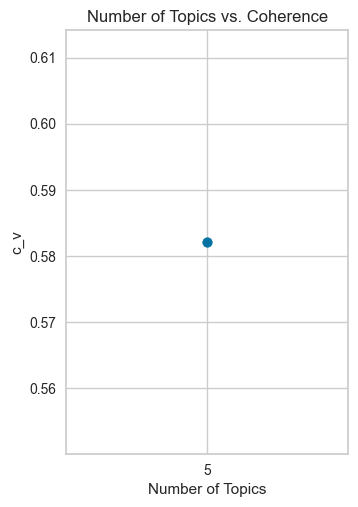

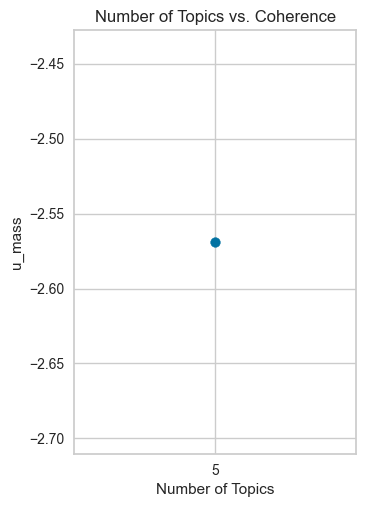

In [26]:
# Concatenate n-grams
def replace_ngram(x):
    for gram in trigrams:
        x = x.replace(gram, '_'.join(gram.split()))
    for gram in bigrams:
        x = x.replace(gram, '_'.join(gram.split()))
    return x


reviews_w_ngrams = pd.DataFrame(amazon_df.cleaned_review.copy())
reviews_w_ngrams.cleaned_review = reviews_w_ngrams.cleaned_review.map(lambda x: replace_ngram(x) if isinstance(x, str) else x)

# tokenize reviews + remove stop words + remove names + remove words with less than 2 characters

# 불용어 처리 추가
print(stop_words)

reviews_w_ngrams = reviews_w_ngrams.cleaned_review.map(lambda x: [word for word in x.split() if word not in stop_words and len(word) > 2] if isinstance(x, str) else x)
reviews_w_ngrams.dropna(axis=0, inplace=True)
reviews_w_ngrams.isnull().sum()



final_reviews = reviews_w_ngrams
final_reviews.dropna(axis=0, inplace=True)

dictionary = corpora.Dictionary(final_reviews)
doc_term_matrix = [dictionary.doc2bow(doc) for doc in final_reviews]

coherence = []
umass = []
px = []

####################### ############################## #######
# 잘 때 25로 바꾸고... 5~25까지 돌리기,, 
for k in range(5,6):
    print('Round: '+str(k))
    Lda = gensim.models.ldamodel.LdaModel
    ldamodel = Lda(doc_term_matrix, num_topics=k, id2word = dictionary, passes=40,\
                iterations=200, chunksize = 10000, eval_every = None)
    
    cm = gensim.models.coherencemodel.CoherenceModel(model=ldamodel, texts=final_reviews,\
                                                    dictionary=dictionary, coherence='c_v')
    mm = gensim.models.coherencemodel.CoherenceModel(model=ldamodel, texts=final_reviews,\
                                                    dictionary=dictionary, coherence='u_mass')
    coherence.append((k,cm.get_coherence()))
    umass.append((k,mm.get_coherence()))
    
    
x_val = [x[0] for x in coherence]
y_val = [x[1] for x in coherence]

x_val_u = [x[0] for x in umass]
y_val_y = [x[1] for x in umass]

plt.subplot(1,2,1)
plt.plot(x_val,y_val)
plt.scatter(x_val,y_val)
plt.title('Number of Topics vs. Coherence')
plt.xlabel('Number of Topics')
plt.ylabel('c_v')
plt.xticks(x_val)
plt.show()

plt.subplot(1,2,2)
plt.plot(x_val_u,y_val_y)
plt.scatter(x_val_u,y_val_y)
plt.title('Number of Topics vs. Coherence')
plt.xlabel('Number of Topics')
plt.ylabel('u_mass')
plt.xticks(x_val_u)
plt.show()

In [27]:
num = 5

Lda = gensim.models.ldamodel.LdaModel
ldamodel = Lda(doc_term_matrix, num_topics=num, id2word = dictionary, passes=40,\
            iterations=200,  chunksize = 10000, eval_every = None, random_state=0)

Lda2 = gensim.models.ldamodel.LdaModel
ldamodel2 = Lda2(doc_term_matrix, num_topics=num, id2word = dictionary, passes=40,\
            iterations=200,  chunksize = 10000, eval_every = None, random_state=0)

# To show initial topics
ldamodel.show_topics(num, num_words=10, formatted=False)

# To show initial topics
ldamodel2_topics = ldamodel2.show_topics(num, num_words=10, formatted=False)

# topic_data =  pyLDAvis.gensim.prepare(ldamodel2, doc_term_matrix, dictionary, mds = 'pcoa')
# pyLDAvis.display(topic_data)

###################
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_'+'v3_0129')

# Create directory if it does not exist
if not os.path.exists('./results'):
    os.makedirs('./results')

# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim.prepare(ldamodel2, doc_term_matrix, dictionary, mds = 'pcoa')
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_prepared_'+ 'v3_0129' +'.html')
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.082056 -0.062115       1        1  35.678795
2     -0.038916 -0.059431       2        1  26.034105
3     -0.017124 -0.156311       3        1  16.577314
0     -0.141436  0.208463       4        1  11.796119
1      0.279532  0.069394       5        1   9.913667, topic_info=                    Term         Freq        Total Category  logprob  loglift
1848            cleanser  1090.000000  1090.000000  Default  30.0000  30.0000
157                cream  2009.000000  2009.000000  Default  29.0000  29.0000
880                clean   573.000000   573.000000  Default  28.0000  28.0000
15                  face  3356.000000  3356.000000  Default  27.0000  27.0000
831                serum  1840.000000  1840.000000  Default  26.0000  26.0000
91            foundation   414.000000   414.000000  Default  25.0000  25.0000
188          moisturizer  1422.000000  1422.000000  Default  24.0000  24.0000
1792             retinol   440.000000   440.000000  Default  23.0000  23.0000
28                   dry  1890.000000  1890.000000  Default  22.0000  22.0000
764                 soft  1092.000000  1092.000000  Default  21.0000  21.0000
1621                 oil   637.000000   637.000000  Default  20.0000  20.0000
22                  acne   722.000000   722.000000  Default  19.0000  19.0000
1227              gentle   772.000000   772.000000  Default  18.0000  18.0000
41             sensitive  1898.000000  1898.000000  Default  17.0000  17.0000
1020             patches   256.000000   256.000000  Default  16.0000  16.0000
162              feeling  1025.000000  1025.000000  Default  15.0000  15.0000
50                 color   327.000000   327.000000  Default  14.0000  14.0000
348               bottle   972.000000   972.000000  Default  13.0000  13.0000
278                shade   202.000000   202.000000  Default  12.0000  12.0000
161            excellent   260.000000   260.000000  Default  11.0000  11.0000
115                feels  1574.000000  1574.000000  Default  10.0000  10.0000
655              absorbs   668.000000   668.000000  Default   9.0000   9.0000
0                   good  2264.000000  2264.000000  Default   8.0000   8.0000
2037            centella   272.000000   272.000000  Default   7.0000   7.0000
283                 oily  1005.000000  1005.000000  Default   6.0000   6.0000
1275             essence   279.000000   279.000000  Default   5.0000   5.0000
646               leaves   839.000000   839.000000  Default   4.0000   4.0000
640               smooth   719.000000   719.000000  Default   3.0000   3.0000
133               sticky   642.000000   642.000000  Default   2.0000   2.0000
187            effective   325.000000   325.000000  Default   1.0000   1.0000
1100                 sea   137.337245   137.983972   Topic1  -6.2936   1.0259
2195              sponge   103.851918   104.513023   Topic1  -6.5731   1.0243
6061                pads    89.643560    90.285902   Topic1  -6.7202   1.0235
299                  pat    64.884834    65.527782   Topic1  -7.0434   1.0208
1024               plump   147.232732   148.858384   Topic1  -6.2240   1.0196
8480               ⭐⭐⭐⭐⭐    57.325587    58.029528   Topic1  -7.1673   1.0184
2471               hydro    50.135593    50.779985   Topic1  -7.3013   1.0178
3913           nongreasy    50.606108    51.276015   Topic1  -7.2920   1.0175
2932          dark_spots    45.394940    46.044909   Topic1  -7.4006   1.0164
4928              mirror    44.131719    44.788647   Topic1  -7.4289   1.0158
303                 soak    39.710103    40.351010   Topic1  -7.5344   1.0146
9269              colour    39.515394    40.214851   Topic1  -7.5393   1.0131
1491        overwhelming    36.087668    36.730105   Topic1  -7.6301   1.0130
2655                pill    35.069285    35.714372   Topic1  -7.6587   1.0124
4420              season    34.050398    34.699453   Topic1  -7.6882 

In [28]:
topic_data = LDAvis_prepared
all_topics = {}
num_terms = 10 # Adjust number of words to represent each topic
lambd = 0.6 # Adjust this accordingly based on tuning above
for i in range(1,num+1): #Adjust this to reflect number of topics chosen for final LDA model
    topic = topic_data.topic_info[topic_data.topic_info.Category == 'Topic'+str(i)].copy()
    topic['relevance'] = topic['loglift']*(1-lambd)+topic['logprob']*lambd
    all_topics['Topic '+str(i)] = topic.sort_values(by='relevance', ascending=False).Term[:num_terms].values

lda2_test_results = pd.DataFrame(all_topics).T
lda2_test_results
# lda2_test_results.to_csv(DATA_PATH+'lda3_test_results.csv', encoding='cp949')

,0,1,2,3,4,5,6,7,8,9
Topic 1,face,cream,feels,well,soft,feeling,hydrated,smooth,absorbs,sticky
Topic 2,moisturizer,acne,sensitive,dry,oily,pores,essence,redness,serum,toner
Topic 3,cleanser,clean,face,oil,gentle,great,dry,cleansing,smell,remove
Topic 4,retinol,cream,serum,excellent,centella,bakuchiol,vegan,effective,good,kit
Topic 5,foundation,patches,color,shade,bb_cream,bottle,dark,half,yellow,pimple


## 브랜드별 평점 4점 이상

## 브랜드별 평점 2점 이하 전체랑 브랜드별

In [29]:
def LDAvis_save(num, name):
    Lda = gensim.models.ldamodel.LdaModel
    ldamodel = Lda(doc_term_matrix, num_topics=num, id2word = dictionary, passes=40,\
                iterations=200,  chunksize = 10000, eval_every = None, random_state=0)

    Lda2 = gensim.models.ldamodel.LdaModel
    ldamodel2 = Lda2(doc_term_matrix, num_topics=num, id2word = dictionary, passes=40,\
                iterations=200,  chunksize = 10000, eval_every = None, random_state=0)

    # To show initial topics
    ldamodel.show_topics(num, num_words=10, formatted=False)

    # To show initial topics
    ldamodel2.show_topics(num, num_words=10, formatted=False)

    # Visualize the topics
    pyLDAvis.enable_notebook()
    LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_'+'v3_0129')

    # Create directory if it does not exist
    if not os.path.exists('./results'):
        os.makedirs('./results')

    LDAvis_prepared = pyLDAvis.gensim.prepare(ldamodel2, doc_term_matrix, dictionary, mds = 'pcoa')
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
    # load the pre-prepared pyLDAvis data from disk
    
    with open(LDAvis_data_filepath, 'rb') as f:
        LDAvis_prepared = pickle.load(f)
    pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_prepared_'+ f'{name}_{num}' +'.html')

In [ ]:
from IPython.display import display

In [36]:
def check_df(num):
    topic_data = LDAvis_prepared
    all_topics = {}
    num_terms = 10  # Adjust number of words to represent each topic
    lambd = 0.6  # Adjust this accordingly based on tuning above

    for i in range(1, num + 1):  # Adjust this to reflect number of topics chosen for final LDA model
        topic = topic_data.topic_info[topic_data.topic_info.Category == 'Topic' + str(i)].copy()
        topic['relevance'] = topic['loglift'] * (1 - lambd) + topic['logprob'] * lambd
        
        # 리스트 길이 보정: max_length 만큼 패딩 (NaN 추가)
        terms = topic.sort_values(by='relevance', ascending=False).Term.tolist()
        all_topics['Topic ' + str(i)] = terms[:num_terms] + [None] * (num_terms - len(terms))

    lda2_test_results = pd.DataFrame.from_dict(all_topics, orient='index')
    return display(lda2_test_results)

# Con∑catenate n-grams
def replace_ngram(x):
    for gram in trigrams:
        x = x.replace(gram, '_'.join(gram.split()))
    for gram in bigrams:
        x = x.replace(gram, '_'.join(gram.split()))
    return x

def check_coherece(reviews_w_ngrams):
    #두개 이어 붙인 거 이_로
    reviews_w_ngrams.cleaned_review = reviews_w_ngrams.cleaned_review.map(lambda x: replace_ngram(x) if isinstance(x, str) else x)

    # 불용어 처리 추가
    print(stop_words)

    # 3개 짜리 트리그램 [word1, word2, word3] + 두이어붙인 거에
    reviews_w_ngrams = reviews_w_ngrams.cleaned_review.map(lambda x: [word for word in x.split() if word not in stop_words and len(word) > 2] if isinstance(x, str) else x)
    reviews_w_ngrams.dropna(axis=0, inplace=True)
    reviews_w_ngrams.isnull().sum()

    final_reviews = reviews_w_ngrams
    final_reviews.dropna(axis=0, inplace=True)

    dictionary = corpora.Dictionary(final_reviews)
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in final_reviews]

    coherence = []
    umass = []
    px = []

    for k in range(3,10):
        print('Round: '+str(k))
        Lda = gensim.models.ldamodel.LdaModel
        ldamodel = Lda(doc_term_matrix, num_topics=k, id2word = dictionary, passes=40,\
                    iterations=200, chunksize = 10000, eval_every = None)
        
        cm = gensim.models.coherencemodel.CoherenceModel(model=ldamodel, texts=final_reviews,\
                                                        dictionary=dictionary, coherence='c_v')
        mm = gensim.models.coherencemodel.CoherenceModel(model=ldamodel, texts=final_reviews,\
                                                        dictionary=dictionary, coherence='u_mass')
        coherence.append((k,cm.get_coherence()))
        umass.append((k,mm.get_coherence()))
        
        
    x_val = [x[0] for x in coherence]
    y_val = [x[1] for x in coherence]

    x_val_u = [x[0] for x in umass]
    y_val_y = [x[1] for x in umass]

    plt.subplot(1,2,1)
    plt.plot(x_val,y_val)
    plt.scatter(x_val,y_val)
    plt.title('Number of Topics vs. Coherence')
    plt.xlabel('Number of Topics')
    plt.ylabel('c_v')
    plt.xticks(x_val)
    plt.show()

    plt.subplot(1,2,2)
    plt.plot(x_val_u,y_val_y)
    plt.scatter(x_val_u,y_val_y)
    plt.title('Number of Topics vs. Coherence')
    plt.xlabel('Number of Topics')
    plt.ylabel('u_mass')
    plt.xticks(x_val_u)
    plt.show()

In [31]:
reviews_w_ngrams = pd.DataFrame(amazon_df_dsa.cleaned_review.copy())
#reviews_w_ngrams = pd.DataFrame(amazon_df_dsa_dr.cleaned_review.copy())
#reviews_w_ngrams = pd.DataFrame(amazon_df_dsa_cs.cleaned_review.copy())
#reviews_w_ngrams = pd.DataFrame(amazon_df_dsa_bj.cleaned_review.copy())
#reviews_w_ngrams = pd.DataFrame(amazon_df_dsa_if.cleaned_review.copy())
#reviews_w_ngrams = pd.DataFrame(amazon_df_dsa_pu.cleaned_review.copy())

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

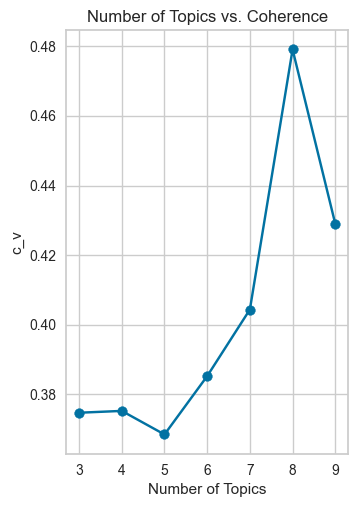

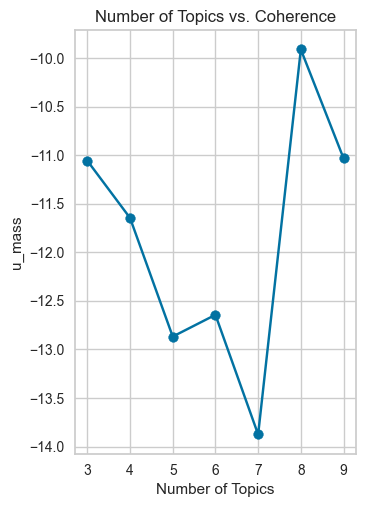

                   0      1          2     3       4        5         6  \
Topic 1         face  cream      feels  well    soft  feeling  hydrated   
Topic 2  moisturizer   acne  sensitive   dry    oily    pores   essence   
Topic 3     cleanser  clean       face   oil  gentle    great       dry   

                 7        8       9  
Topic 1     smooth  absorbs  sticky  
Topic 2    redness    serum   toner  
Topic 3  cleansing    smell  remove  


,0,1,2,3,4,5,6,7,8,9
Topic 1,face,cream,feels,well,soft,feeling,hydrated,smooth,absorbs,sticky
Topic 2,moisturizer,acne,sensitive,dry,oily,pores,essence,redness,serum,toner
Topic 3,cleanser,clean,face,oil,gentle,great,dry,cleansing,smell,remove


                   0      1          2          3         4          5  \
Topic 1         face  cream      feels       well      soft    feeling   
Topic 2  moisturizer   acne  sensitive        dry      oily      pores   
Topic 3     cleanser  clean       face        oil    gentle      great   
Topic 4      retinol  cream      serum  excellent  centella  bakuchiol   

                6          7        8       9  
Topic 1  hydrated     smooth  absorbs  sticky  
Topic 2   essence    redness    serum   toner  
Topic 3       dry  cleansing    smell  remove  
Topic 4     vegan  effective     good     kit  


,0,1,2,3,4,5,6,7,8,9
Topic 1,face,cream,feels,well,soft,feeling,hydrated,smooth,absorbs,sticky
Topic 2,moisturizer,acne,sensitive,dry,oily,pores,essence,redness,serum,toner
Topic 3,cleanser,clean,face,oil,gentle,great,dry,cleansing,smell,remove
Topic 4,retinol,cream,serum,excellent,centella,bakuchiol,vegan,effective,good,kit


                   0        1          2          3         4          5  \
Topic 1         face    cream      feels       well      soft    feeling   
Topic 2  moisturizer     acne  sensitive        dry      oily      pores   
Topic 3     cleanser    clean       face        oil    gentle      great   
Topic 4      retinol    cream      serum  excellent  centella  bakuchiol   
Topic 5   foundation  patches      color      shade  bb_cream     bottle   

                6          7        8       9  
Topic 1  hydrated     smooth  absorbs  sticky  
Topic 2   essence    redness    serum   toner  
Topic 3       dry  cleansing    smell  remove  
Topic 4     vegan  effective     good     kit  
Topic 5      dark       half   yellow  pimple  


,0,1,2,3,4,5,6,7,8,9
Topic 1,face,cream,feels,well,soft,feeling,hydrated,smooth,absorbs,sticky
Topic 2,moisturizer,acne,sensitive,dry,oily,pores,essence,redness,serum,toner
Topic 3,cleanser,clean,face,oil,gentle,great,dry,cleansing,smell,remove
Topic 4,retinol,cream,serum,excellent,centella,bakuchiol,vegan,effective,good,kit
Topic 5,foundation,patches,color,shade,bb_cream,bottle,dark,half,yellow,pimple


                   0        1          2          3         4          5  \
Topic 1         face    cream      feels       well      soft    feeling   
Topic 2  moisturizer     acne  sensitive        dry      oily      pores   
Topic 3     cleanser    clean       face        oil    gentle      great   
Topic 4      retinol    cream      serum  excellent  centella  bakuchiol   
Topic 5   foundation  patches      color      shade  bb_cream     bottle   
Topic 6         None     None       None       None      None       None   

                6          7        8       9  
Topic 1  hydrated     smooth  absorbs  sticky  
Topic 2   essence    redness    serum   toner  
Topic 3       dry  cleansing    smell  remove  
Topic 4     vegan  effective     good     kit  
Topic 5      dark       half   yellow  pimple  
Topic 6      None       None     None    None  


,0,1,2,3,4,5,6,7,8,9
Topic 1,face,cream,feels,well,soft,feeling,hydrated,smooth,absorbs,sticky
Topic 2,moisturizer,acne,sensitive,dry,oily,pores,essence,redness,serum,toner
Topic 3,cleanser,clean,face,oil,gentle,great,dry,cleansing,smell,remove
Topic 4,retinol,cream,serum,excellent,centella,bakuchiol,vegan,effective,good,kit
Topic 5,foundation,patches,color,shade,bb_cream,bottle,dark,half,yellow,pimple
Topic 6,None,None,None,None,None,None,None,None,None,None


KeyboardInterrupt: 

In [37]:
check_coherece(reviews_w_ngrams)
for i in range(3,10):
    LDAvis_save(i, 'dsa_all')
    check_df(i)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

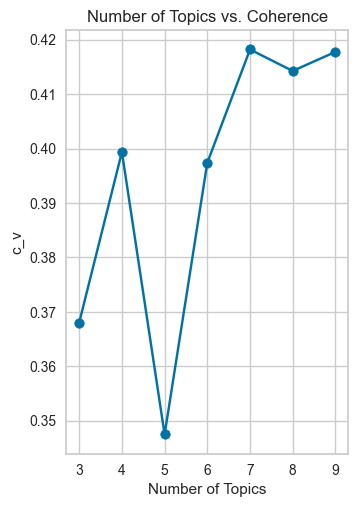

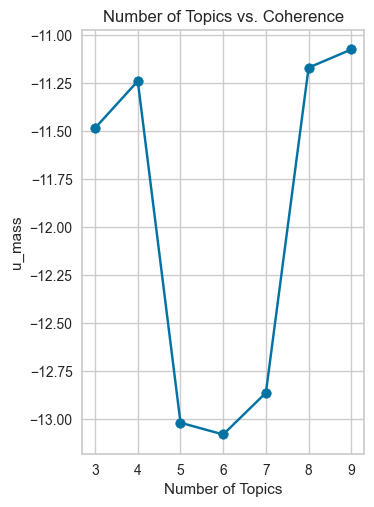

                   0      1          2     3       4        5         6  \
Topic 1         face  cream      feels  well    soft  feeling  hydrated   
Topic 2  moisturizer   acne  sensitive   dry    oily    pores   essence   
Topic 3     cleanser  clean       face   oil  gentle    great       dry   

                 7        8       9  
Topic 1     smooth  absorbs  sticky  
Topic 2    redness    serum   toner  
Topic 3  cleansing    smell  remove  
                   0      1          2          3         4          5  \
Topic 1         face  cream      feels       well      soft    feeling   
Topic 2  moisturizer   acne  sensitive        dry      oily      pores   
Topic 3     cleanser  clean       face        oil    gentle      great   
Topic 4      retinol  cream      serum  excellent  centella  bakuchiol   

                6          7        8       9  
Topic 1  hydrated     smooth  absorbs  sticky  
Topic 2   essence    redness    serum   toner  
Topic 3       dry  cleansing    

KeyboardInterrupt: 

In [33]:
#reviews_w_ngrams = pd.DataFrame(amazon_df_dsa.cleaned_review.copy())
reviews_w_ngrams = pd.DataFrame(amazon_df_dsa_dr.cleaned_review.copy())
#reviews_w_ngrams = pd.DataFrame(amazon_df_dsa_cs.cleaned_review.copy())
#reviews_w_ngrams = pd.DataFrame(amazon_df_dsa_bj.cleaned_review.copy())
#reviews_w_ngrams = pd.DataFrame(amazon_df_dsa_if.cleaned_review.copy())
#reviews_w_ngrams = pd.DataFrame(amazon_df_dsa_pu.cleaned_review.copy())

check_coherece(reviews_w_ngrams)
for i in range(3,10):
    LDAvis_save(i, "dr")
    check_df(i)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

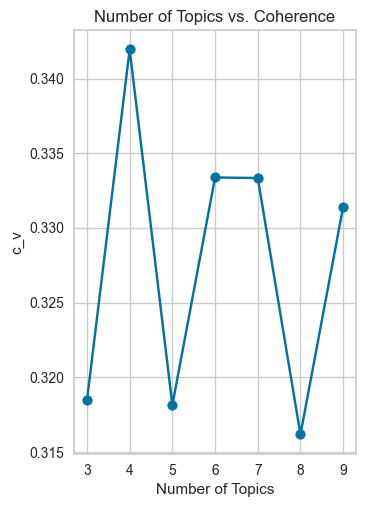

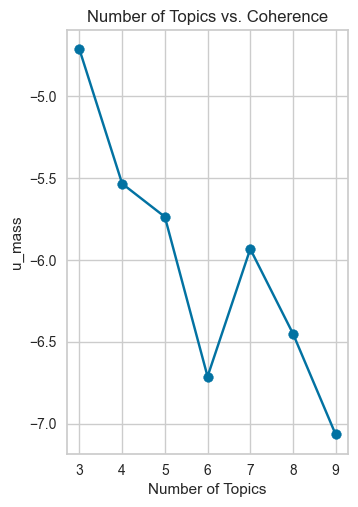

,0,1,2,3,4,5,6,7,8,9
Topic 1,cream,toner,serum,moisturizer,feels,great,moisturizing,sensitive,well,absorbs
Topic 2,face,acne,red,difference,dry,days,pores,felt,sensitive,different
Topic 3,cleanser,clean,face,oil,smell,smells,scent,feeling,gentle,soft
Topic 4,retinol,foundation,color,shade,bakuchiol,natural,cushion,bb_cream,cream,extract
Topic 5,eyes,eye_cream,eye,kit,excellent,good,centella,dark_circles,vegan,wonder


In [51]:
#reviews_w_ngrams = pd.DataFrame(amazon_df_dsa.cleaned_review.copy())
#reviews_w_ngrams = pd.DataFrame(amazon_df_dsa_dr.cleaned_review.copy())
reviews_w_ngrams = pd.DataFrame(amazon_df_dsa_cs.cleaned_review.copy())
#reviews_w_ngrams = pd.DataFrame(amazon_df_dsa_bj.cleaned_review.copy())
#reviews_w_ngrams = pd.DataFrame(amazon_df_dsa_if.cleaned_review.copy())
#reviews_w_ngrams = pd.DataFrame(amazon_df_dsa_pu.cleaned_review.copy())

check_coherece(reviews_w_ngrams)
for i in range(3,10):
    LDAvis_save(i, "cs")
    check_df(i)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

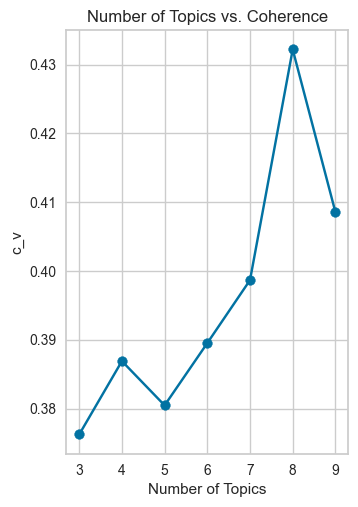

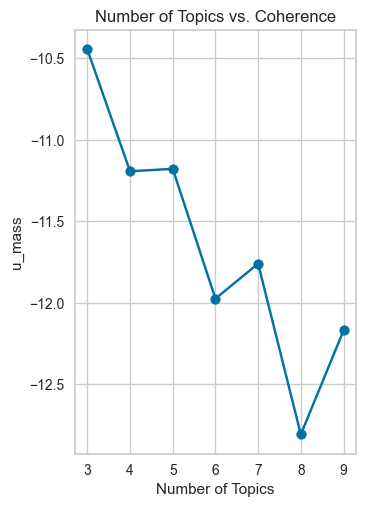

,0,1,2,3,4,5,6,7,8,9
Topic 1,cream,toner,serum,moisturizer,feels,great,moisturizing,sensitive,well,absorbs
Topic 2,face,acne,red,difference,dry,days,pores,felt,sensitive,different
Topic 3,cleanser,clean,face,oil,smell,smells,scent,feeling,gentle,soft
Topic 4,retinol,foundation,color,shade,bakuchiol,natural,cushion,bb_cream,cream,extract
Topic 5,eyes,eye_cream,eye,kit,excellent,good,centella,dark_circles,vegan,wonder


In [52]:
#reviews_w_ngrams = pd.DataFrame(amazon_df_dsa.cleaned_review.copy())
#reviews_w_ngrams = pd.DataFrame(amazon_df_dsa_dr.cleaned_review.copy())
#reviews_w_ngrams = pd.DataFrame(amazon_df_dsa_cs.cleaned_review.copy())
reviews_w_ngrams = pd.DataFrame(amazon_df_dsa_bj.cleaned_review.copy())
#reviews_w_ngrams = pd.DataFrame(amazon_df_dsa_if.cleaned_review.copy())
#reviews_w_ngrams = pd.DataFrame(amazon_df_dsa_pu.cleaned_review.copy())

check_coherece(reviews_w_ngrams)
for i in range(3,10):
    LDAvis_save(i, "bj")
    check_df(i)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

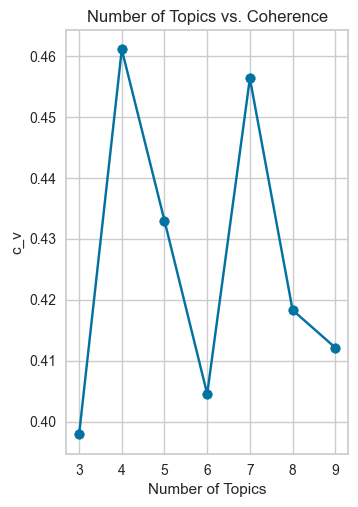

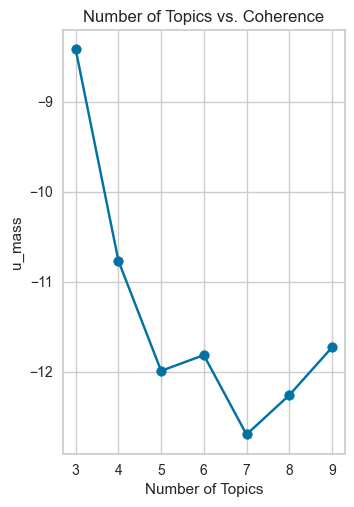

,0,1,2,3,4,5,6,7,8,9
Topic 1,cream,toner,serum,moisturizer,feels,great,moisturizing,sensitive,well,absorbs
Topic 2,face,acne,red,difference,dry,days,pores,felt,sensitive,different
Topic 3,cleanser,clean,face,oil,smell,smells,scent,feeling,gentle,soft
Topic 4,retinol,foundation,color,shade,bakuchiol,natural,cushion,bb_cream,cream,extract
Topic 5,eyes,eye_cream,eye,kit,excellent,good,centella,dark_circles,vegan,wonder


In [53]:
#reviews_w_ngrams = pd.DataFrame(amazon_df_dsa.cleaned_review.copy())
#reviews_w_ngrams = pd.DataFrame(amazon_df_dsa_dr.cleaned_review.copy())
#reviews_w_ngrams = pd.DataFrame(amazon_df_dsa_cs.cleaned_review.copy())
#reviews_w_ngrams = pd.DataFrame(amazon_df_dsa_bj.cleaned_review.copy())
reviews_w_ngrams = pd.DataFrame(amazon_df_dsa_if.cleaned_review.copy())
#reviews_w_ngrams = pd.DataFrame(amazon_df_dsa_pu.cleaned_review.copy())

check_coherece(reviews_w_ngrams)
for i in range(3,10):
    LDAvis_save(i, "if")
    check_df(i)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

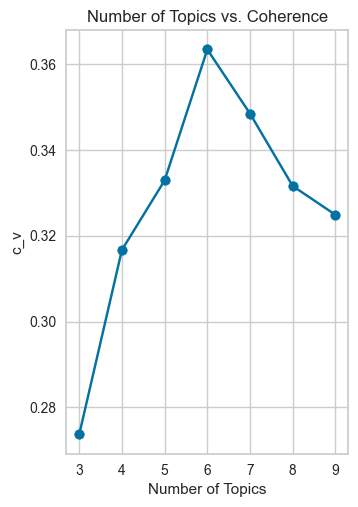

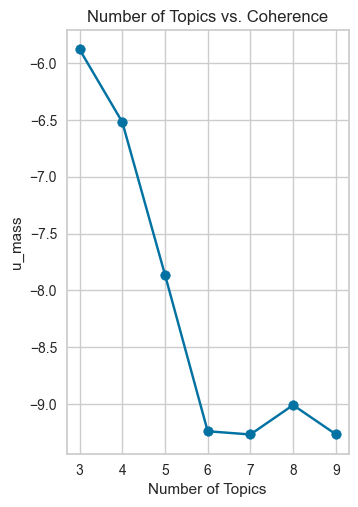

,0,1,2,3,4,5,6,7,8,9
Topic 1,cream,toner,serum,moisturizer,feels,great,moisturizing,sensitive,well,absorbs
Topic 2,face,acne,red,difference,dry,days,pores,felt,sensitive,different
Topic 3,cleanser,clean,face,oil,smell,smells,scent,feeling,gentle,soft
Topic 4,retinol,foundation,color,shade,bakuchiol,natural,cushion,bb_cream,cream,extract
Topic 5,eyes,eye_cream,eye,kit,excellent,good,centella,dark_circles,vegan,wonder


In [54]:
#reviews_w_ngrams = pd.DataFrame(amazon_df_dsa.cleaned_review.copy())
#reviews_w_ngrams = pd.DataFrame(amazon_df_dsa_dr.cleaned_review.copy())
#reviews_w_ngrams = pd.DataFrame(amazon_df_dsa_cs.cleaned_review.copy())
#reviews_w_ngrams = pd.DataFrame(amazon_df_dsa_bj.cleaned_review.copy())
#reviews_w_ngrams = pd.DataFrame(amazon_df_dsa_if.cleaned_review.copy())
reviews_w_ngrams = pd.DataFrame(amazon_df_dsa_pu.cleaned_review.copy())

check_coherece(reviews_w_ngrams)
for i in range(3,10):
    LDAvis_save(i,"pu")
    check_df(i)